In [1]:
import random, uuid
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx

In [18]:
class LeakyIntegrateAndFireNeuron(object):
    def __init__(self, tau=0.0255, R=5.1, threshold=1.0, reset_potential=0.0, dt=0.001, name='Neuron'):
        self.tau = tau  # Membrane time constant
        self.R = R  # Membrane resistance
        self.threshold = threshold  # Firing threshold
        self.reset_potential = reset_potential  # Reset potential
        self.membrane_potential = reset_potential  # Current membrane potential
        self.dt = dt
        self.spiking = False
        self.log_potential = [reset_potential]  # Log of membrane potentials
        self.log_spikes = [False]  # Log of spike events
        self.event_times = [0]
        self.last_firing_time = -float('inf')
        self.pre_synapses = []
        self.post_synapses = []
        self.current = 0
        self.last_t = 0
        self.uuid = uuid.uuid4()
        self.name = name
    
    def getUUID(self):
        return str(self.uuid)

    def update(self, t):
        # Update timer
        diff_t = t - self.last_t
        self.last_t = t
        # Logging for plot beauty
        if diff_t > 1:
            raise ValueError("Update is not ready to use!")
            self.event_times.append(t-1)
            self.log_potential.append(self.membrane_potential)
            self.log_spikes.append(False)
        # Update the membrane potential based on the current input
        delta_v = (-self.membrane_potential + (self.current * self.R)) * (diff_t * dt) / self.tau
        self.membrane_potential += delta_v
        self.current = 0
        # Logging
        self.event_times.append(t)
        self.log_potential.append(self.membrane_potential)

        # Check if the membrane potential exceeds the firing threshold
        if self.membrane_potential >= self.threshold:
            self.spiking = True
            self.last_firing_time = t  # Reset time since last firing
            self.log_potential[-1] = self.threshold
            self.log_spikes.append(True)  # Log a spike event
            self.membrane_potential = self.reset_potential  # Reset the membrane potential
            involved = self.transmitSpike()
            self.learn(t)
            return involved
        else:
            self.spiking = False
            self.log_spikes.append(False)  # Log no spike event
            return set()

    def learn(self, t):
        if not self.spiking:
            return
        # reinforcement
        for synapse in self.pre_synapses:
            node = synapse.pre
            last_t = node.last_firing_time
            dt = t - last_t
            dt *= self.dt
            dw = synapse.update_weight(dt)
            #dw = synapse.weight * kw
            synapse.weight += dw
        # de-reinforcement
        for synapse in self.post_synapses:
            node = synapse.post
            last_t = node.last_firing_time
            dt = last_t - t
            dt *= self.dt
            dw = synapse.update_weight(dt)
            #dw = synapse.weight * kw
            synapse.weight += dw

    def getMembranePotential(self):
        return self.membrane_potential
    
    def transmitSpike(self):
        involved = set()
        for synapse in self.post_synapses:
            node = synapse.forward()
            involved.add(node)
        return involved

    def getLogSince(self, t0):
        return self.log_potential[t0:], self.log_spikes[t0:], self.event_times[t0:]

    def plotLog(self, t0=0, subplot=None):
        p, s, t = self.getLogSince(t0)
        time_array = np.array(t)*self.dt
        spike_list = [p[i] if spike else None for i, spike in enumerate(s)]
        if subplot is None:
            subplot = plt
            plt.figure(figsize=(8, 3))
        subplot.plot(time_array, p, label='Membrane Potential')
        subplot.plot(time_array, spike_list, 'ro', label='Spikes')
        #subplot.legend(loc='center left', bbox_to_anchor=(1, 0.52))
        if subplot == plt:
            subplot.xlabel('Time')
            subplot.ylabel('Membrane Potential')
            subplot.ylim([self.reset_potential, self.threshold*1.1])
            subplot.title('Membrane Potential of ' + self.name)
            subplot.show()
        else:
            subplot.set(xlabel='Time', ylabel='Membrane Potential',
                        title='Membrane Potential of ' + self.name,
                        ylim=[self.reset_potential, self.threshold])
            #subplot.set_xticks([])
            #subplot.set_yticks([])



In [64]:
class Synapse(object):
    def __init__(self, pre, post, weight, synapse_type='base'):
        self.weight = weight  # Initial synaptic weight
        self.pre = pre
        self.post = post
        self.synapse_type = synapse_type

    def forward(self):
        if self.pre.spiking:
            self.post.current += self.weight
        return self.post

    def update_weight(self, dt):
        if self.synapse_type == 'base':
            return 0
        elif self.synapse_type == 'hebb':
            return STDP(dt)
        else:
            raise ValueError("Encountered unknown synapse type value:" + self.synapse_type)

def connectNodes(pre, post, weight, synapse_type='base'):
    s = Synapse(pre, post, weight, synapse_type=synapse_type)
    pre.post_synapses.append(s)
    post.pre_synapses.append(s)
    return s

def STDP(dt):
    # Define STDP parameters
    alpha_pos = 0.1 #0.01  # Positive learning rate
    alpha_neg = -0.1 #-0.01  # Negative learning rate
    tau_pos = 0.1  # Positive time constant (window of eligibility)
    tau_neg = 0.1  # Negative time constant (window of eligibility)
    
    if dt > 0:  # Presynaptic spike before postsynaptic spike (positive timing)
        weight_update = alpha_pos * np.exp(-dt / tau_pos)
    elif dt < 0:  # Postsynaptic spike before presynaptic spike (negative timing)
        weight_update = alpha_neg * np.exp(dt / tau_neg)
    else:
        #weight_update = 0
        weight_update = alpha_pos # when dt==0.0, the pre spike directly caused the post_spike, so weight should be reinforced
    return weight_update

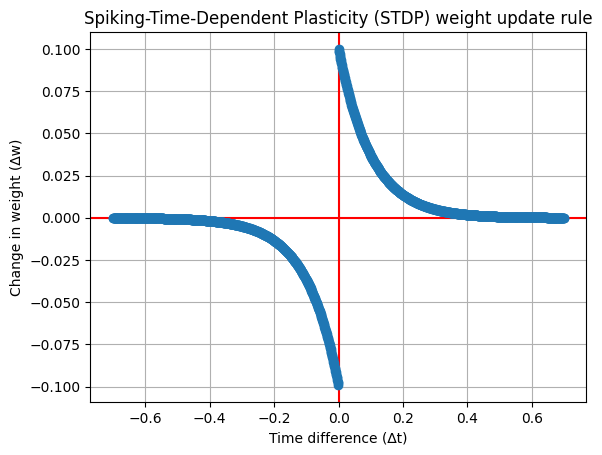

In [94]:
#'''
ts = np.arange(-.7, .7, .001)
ws = np.array(list(map(STDP, ts)))
plt.axhline(0,color='red') # x = 0
plt.axvline(0,color='red') # y = 0
plt.plot(ts, ws, 'o')
plt.grid(True)
plt.xlabel('Time difference (∆t)')
plt.ylabel('Change in weight (∆w)')
plt.title('Spiking-Time-Dependent Plasticity (STDP) weight update rule')
plt.show()
#'''

In [108]:
class LeakySNN:
    def __init__(self, network_shape, dt, weight=None):
        self.n_input = network_shape[0]
        self.n_output = network_shape[-1]
        self.network_shape = network_shape
        self.dt = dt
        self.t = 0
        if weight is None:
            self.initRandom(synapse_type='hebb')
        else:
            self.initSimple(weight, synapse_type='hebb')

    def update(self, input_array):
        raise ValueError("The update method for LeakySNN is deprecated, use fullUpdate instead")
        self.t += 1
        involved_neurons = set()
        for i in range(len(self.inputs)):
            node = self.layers[0][i]
            if input_array[i] == 0:
                node.current = 0
                continue
            node = self.layers[0][i]
            node.current = input_array[i]
            involved_neurons.add(node)
        while len(involved_neurons) > 0:
            iter_neurons = involved_neurons.copy()
            involved_neurons = set()
            for node in iter_neurons:
                involved = node.update(self.t)
                involved_neurons.update(involved)

    def fullUpdate(self, input_array):
        self.t += 1
        for i in range(len(self.layers[0])):
            node = self.layers[0][i]
            node.current = input_array[i]
        for i in range(len(self.layers)):
            layer = self.layers[i]
            for j in range(len(layer)):
                node = self.layers[i][j]
                node.update(self.t)
                '''
        for i in range(len(self.layers)):
            layer = self.layers[i]
            for j in range(len(layer)):
                node = self.layers[i][j]
                node.learn(self.t)'''

    def initSimple(self, weight, synapse_type='base'):
        self.layers = []
        self.inputs = []
        self.outputs = []
        for i in range(len(self.network_shape)):
            layer = [LeakyIntegrateAndFireNeuron(dt=self.dt) for j in range(self.network_shape[i])]
            self.layers.append(layer)
        for i in range(len(self.network_shape)-1):
            for a in self.layers[i]:
                for b in self.layers[i+1]:
                    connectNodes(a, b, weight, synapse_type=synapse_type)

    def initRandom(self, synapse_type='base'):
        self.layers = []
        self.inputs = []
        self.outputs = []
        for i in range(len(self.network_shape)):
            layer = [LeakyIntegrateAndFireNeuron(dt=self.dt) for j in range(self.network_shape[i])]
            self.layers.append(layer)
        for i in range(len(self.network_shape)-1):
            for a in self.layers[i]:
                for b in self.layers[i+1]:
                    connectNodes(a, b, weight=(random.random()*2), synapse_type=synapse_type)

    def plotActivity(self):
        for layer in self.layers:
          for node in layer:
              node.plotLog()

    def plotActivitySince(self, t0, layerwise=False):
        rows = len(self.layers)
        cols = len(max(self.layers, key=len))
        num_neurons = sum(self.network_shape)
        if layerwise: # Under layerwise, neurons in the same layer are plotted in the same row. Use this for larger networks
            fig, ax = plt.subplots(rows, cols, figsize=(14/3*cols, 5/3*rows))
        else:         # Otherwise, each neuron takes up its own row. This is suitable for smaller networks.
            fig, ax = plt.subplots(num_neurons, 1, figsize=(6, 5/3*num_neurons))
        i_neuron = 0
        for i in range(len(self.layers)):
            layer = self.layers[i]
            for j in range(len(layer)):
                node = layer[j]
                if layerwise:
                    node.plotLog(t0=t0, subplot=ax[i, j])
                else:
                    node.plotLog(t0=t0, subplot=ax[i_neuron])
                    i_neuron += 1
            if layerwise:
                for j in range(len(layer), cols):
                    ax[i, j].remove()  # don't display empty ax (only applicable under layerwise)
        plt.tight_layout()
        plt.show()
        # node.plotLog(t0=t0)
    
    def visualizeLayers(self):
        # Create a directed graph
        G = nx.DiGraph()
        # Add nodes to the graph
        for layer_idx, layer in enumerate(self.layers):
            for neuron_idx, neuron in enumerate(layer):
                G.add_node(neuron.getUUID())
                # Add an attribute to each neuron for coloring
                G.nodes[neuron.getUUID()]['membrane_potential'] = neuron.membrane_potential

        # Add edges (synapses) to the graph
        for layer_idx, layer in enumerate(self.layers[:-1]):
            for neuron_idx, neuron in enumerate(layer):
                for synapse in neuron.post_synapses:
                    G.add_edge(synapse.pre.getUUID(), synapse.post.getUUID(), weight=synapse.weight)

        # Set the positions of the nodes based on layers
        pos = {}
        for layer_idx, layer in enumerate(self.layers):
            y = -layer_idx
            x_start = -(len(layer) - 1) / 2  # Calculate starting x-position for the layer
            for neuron_idx, neuron in enumerate(layer):
                x = x_start + neuron_idx  # Update x-position based on neuron index
                pos[neuron.getUUID()] = (x, y)

       # Get the weights of the edges
        edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]

        # Define the colormap based on the edge weights
        cmap_edges = cm.get_cmap('coolwarm')
        cmap_nodes = cm.get_cmap('cividis')

        # Draw the neural network, coloring nodes based on layers
        node_colors = [G.nodes[neuron]['membrane_potential'] for neuron in G.nodes]
        if min(edge_weights) != max(edge_weights):
            edge_colors = [cmap_edges((weight - min(edge_weights)) / (max(edge_weights) - min(edge_weights))) for weight in edge_weights]
        else:
            edge_colors='gray'
        nx.draw(G, pos, with_labels=False, node_color=node_colors, cmap=cmap_nodes, edge_color=edge_colors, arrows=False)

        # Create a colorbar legend for the edge weights
        sm = cm.ScalarMappable(cmap=cmap_edges)
        sm.set_array(edge_weights)
        cbar = plt.colorbar(sm)
        cbar.set_label('Edge Weight')
        # Create a colorbar legend for neuron membrane potentials
        sm = cm.ScalarMappable(cmap=cmap_nodes)
        sm.set_array(edge_weights)
        cbar = plt.colorbar(sm)
        cbar.set_label('Membrane potential')

        # Show the plot
        plt.show()
        del G
        plt.clf() 
        

## Experiment 1: Classical Conditioning (US -> CS)

<ipython-input-108-c54c04853c27>:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_edges = cm.get_cmap('coolwarm')
<ipython-input-108-c54c04853c27>:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_nodes = cm.get_cmap('cividis')
<ipython-input-108-c54c04853c27>:146: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
<ipython-input-108-c54c04853c27>:151: MatplotlibDeprecationWarning: Una

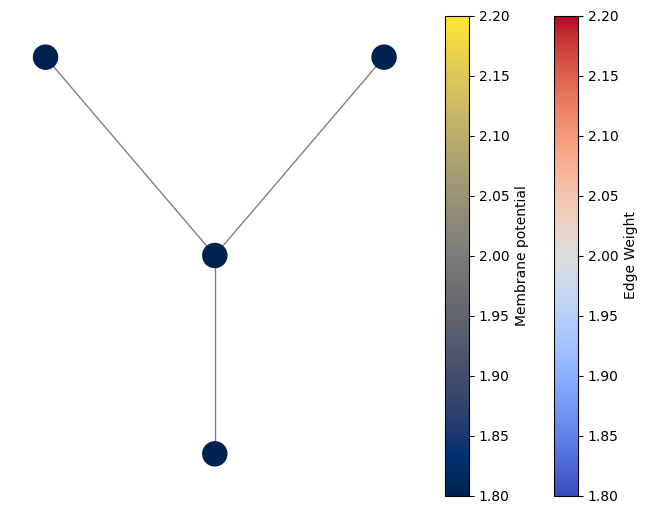

Control: Only CS input before learning


<Figure size 640x480 with 0 Axes>

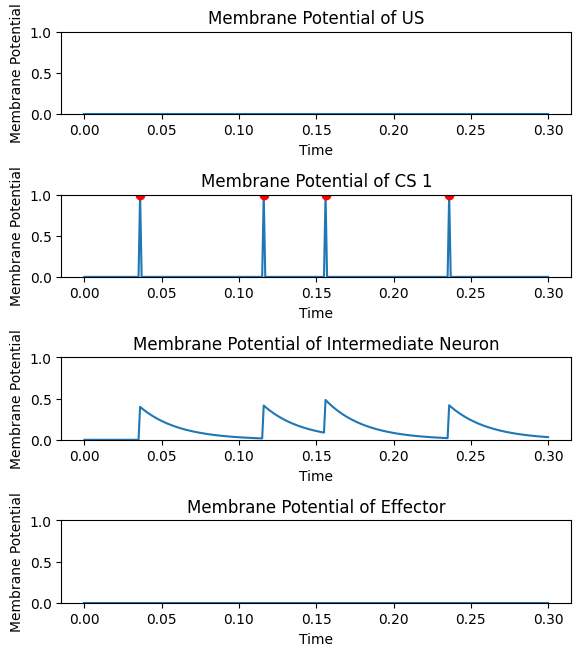

Control: Only CS input before learning


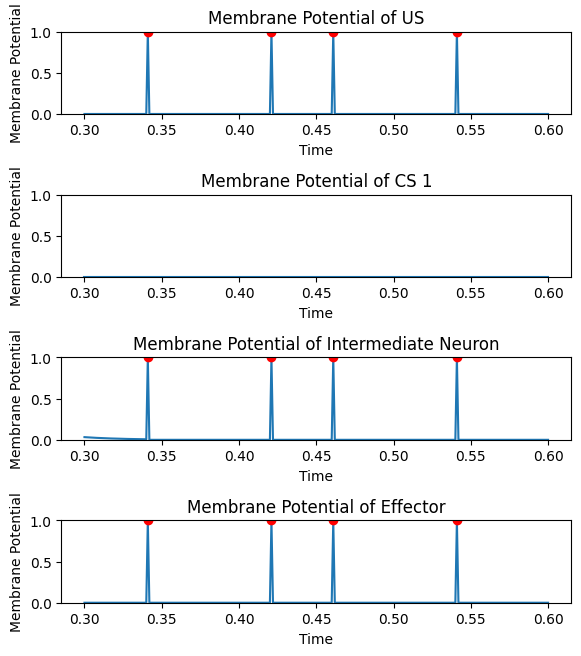

Learning: Both US input and CS input


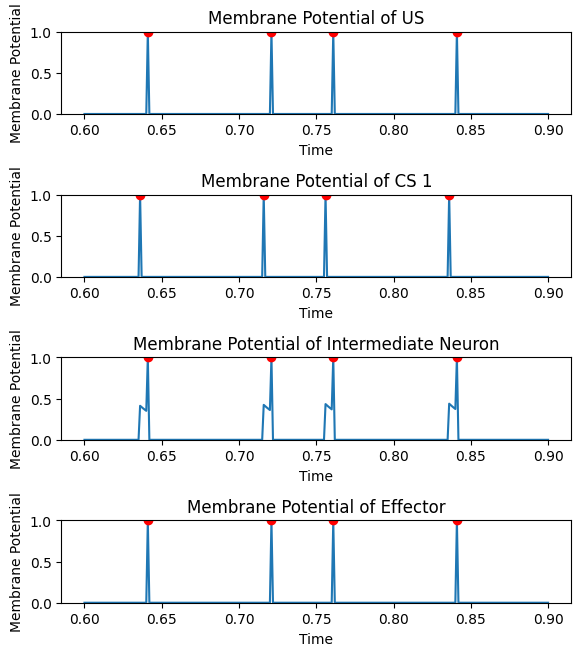

Result: Only CS input after learning


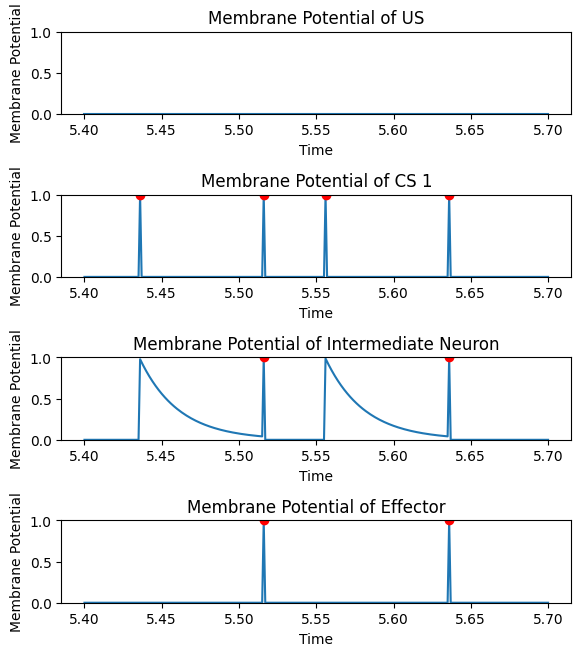

'\n# Simulate the neuron\nnum_steps = int(sim_time / dt)\nfor step in range(num_steps):\n    input_current = getSpikeTrain(step)\n    x = [input_current for i in range(net.n_input)]\n    net.fullUpdate(x)\nnet.plotActivitySince(1000)\n\n# Simulate the neuron\nnum_steps = int(sim_time / dt)\nfor step in range(num_steps):\n    input_current = getSpikeTrain(step)\n    x = [input_current for i in range(net.n_input)]\n    net.fullUpdate(x)\nnet.plotActivitySince(2000)\n'

In [109]:
# Set simulation parameters
dt = 0.001  # Time step
sim_time = 0.3  # Simulation time

net = LeakySNN((2,1,1), dt, weight=2.0)
net.visualizeLayers()
net.layers[0][0].name = 'US'
net.layers[0][1].name = 'CS 1'
net.layers[1][0].name = 'Intermediate Neuron'
net.layers[2][0].name = 'Effector'

us2intermediate_synapse = net.layers[0][0].post_synapses[0]
us2intermediate_synapse.weight = 5.0

effector_synapse = net.layers[2][0].pre_synapses[0]
effector_synapse.synapse_type = 'base'
effector_synapse.weight = 5.0

def getSpikeTrain(step):
    #'''
    if 0 < step%100 < 80:
        if step % 40 == 0:
            return 5.0
    '''
    if 200 < step < 300:
        if step % 10 == 0:
            return 5.0
    '''
    return 0.0

# Simulate the neuron
trial = 0
num_steps = int(sim_time / dt)
learning_cycle = 15

print("Control: Only CS input before learning")
for step in range(num_steps):
    US_input = 0
    CS1_input = getSpikeTrain(step + 5)
    x = [US_input,CS1_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

print("Control: Only CS input before learning")
for step in range(num_steps):
    US_input = getSpikeTrain(step)
    CS1_input = 0
    x = [US_input,CS1_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

print("Learning: Both US input and CS input")
for step in range(num_steps):
    US_input = getSpikeTrain(step)
    CS1_input = getSpikeTrain(step + 5)
    x = [US_input,CS1_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

for i in range(learning_cycle):
    for step in range(num_steps):
        US_input = getSpikeTrain(step)
        CS1_input = getSpikeTrain(step + 5)
        CS2_input = 0
        x = [US_input,CS1_input, CS2_input]
        net.fullUpdate(x)
    #net.plotActivitySince(trial * num_steps)
    trial += 1

print("Result: Only CS input after learning")
for step in range(num_steps):
    US_input = 0
    CS1_input = getSpikeTrain(step + 5)
    x = [US_input,CS1_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1
'''
# Simulate the neuron
num_steps = int(sim_time / dt)
for step in range(num_steps):
    input_current = getSpikeTrain(step)
    x = [input_current for i in range(net.n_input)]
    net.fullUpdate(x)
net.plotActivitySince(1000)

# Simulate the neuron
num_steps = int(sim_time / dt)
for step in range(num_steps):
    input_current = getSpikeTrain(step)
    x = [input_current for i in range(net.n_input)]
    net.fullUpdate(x)
net.plotActivitySince(2000)
'''

## Experiment 2: Transfer Conditioning (US -> CS 1 -> CS 2)

<ipython-input-108-c54c04853c27>:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_edges = cm.get_cmap('coolwarm')
<ipython-input-108-c54c04853c27>:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_nodes = cm.get_cmap('cividis')
<ipython-input-108-c54c04853c27>:146: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
<ipython-input-108-c54c04853c27>:151: MatplotlibDeprecationWarning: Una

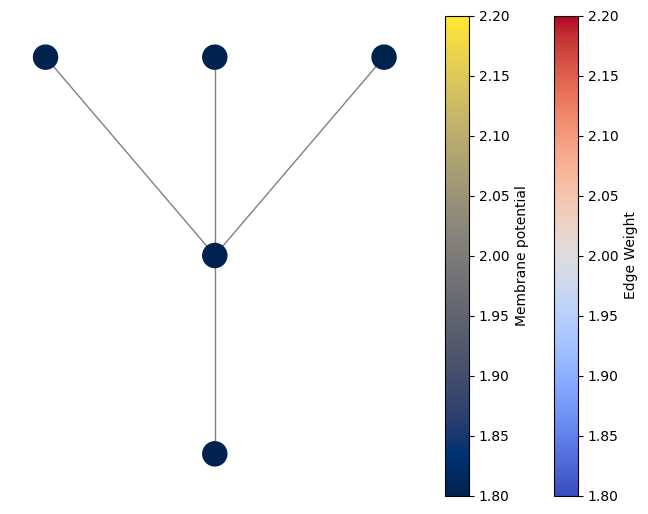


Control: Only CS input before learning



<Figure size 640x480 with 0 Axes>

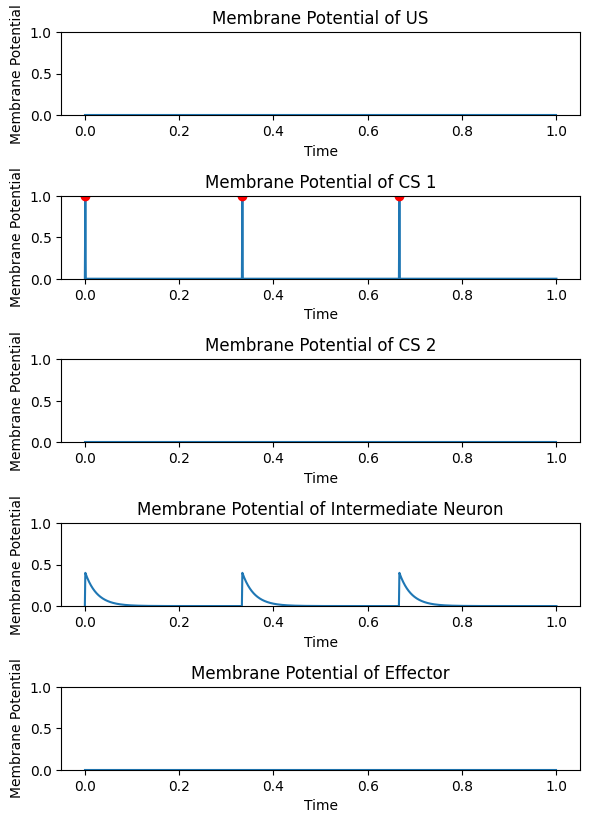


Control: Only CS input before learning



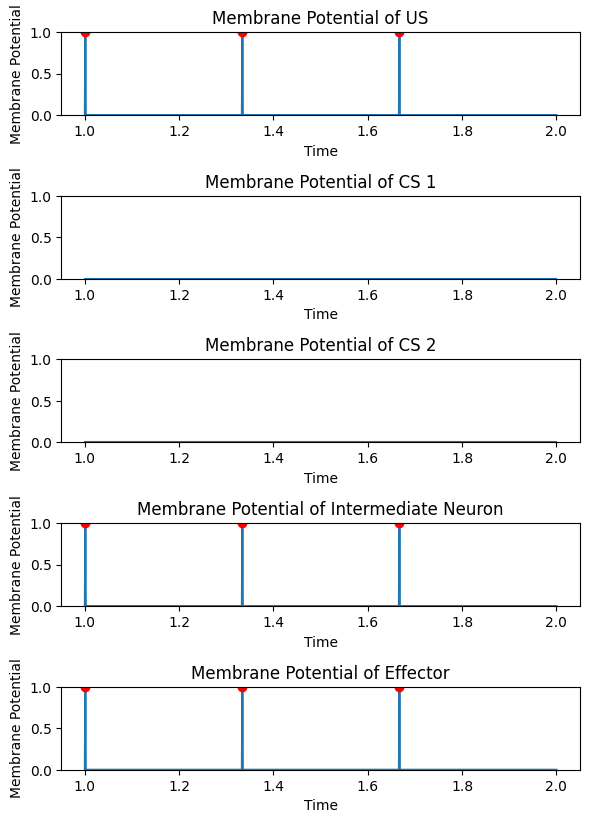


Learning: Both US input and CS input



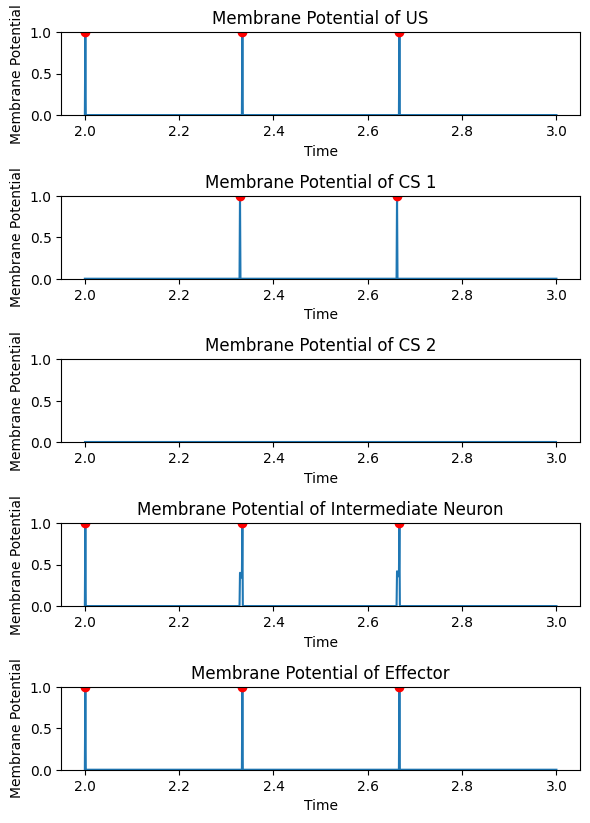


Result: Only CS input after learning



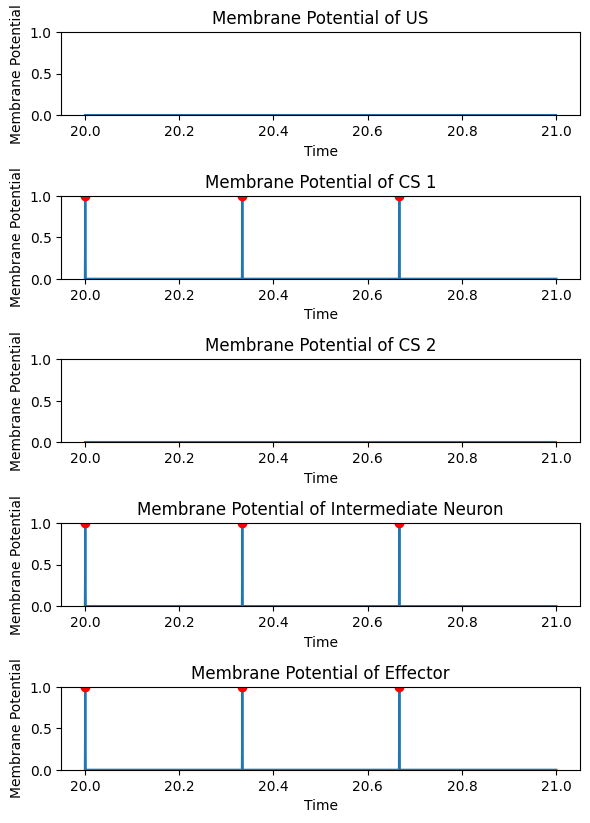


----------------------------------------
We now have classical conditioning on CS 1 established!
----------------------------------------


Control: Only CS 2 input before learning



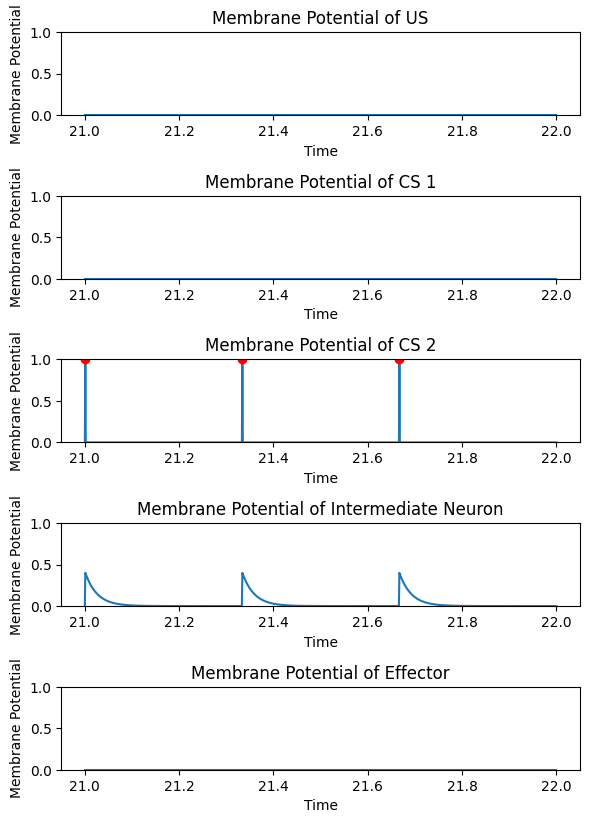


Learning: CS 1 and CS 2



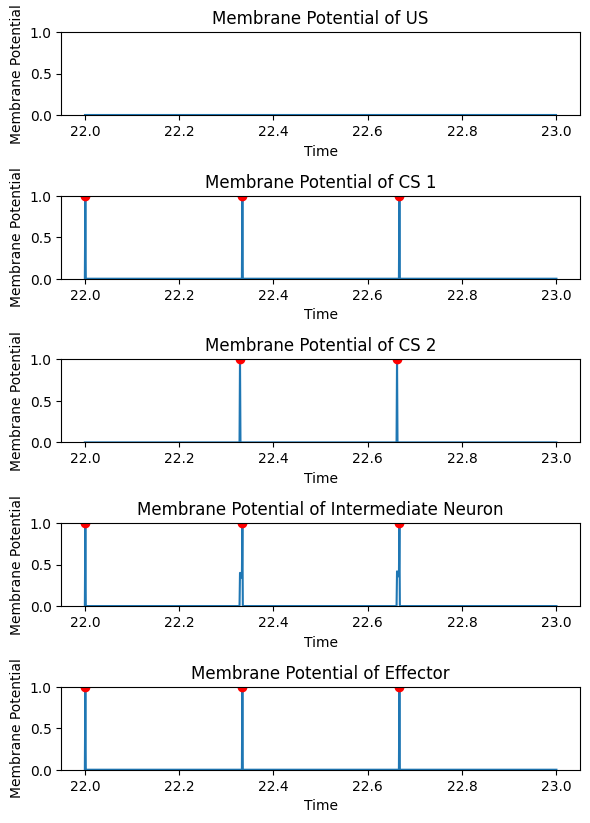


Result: Only CS 2 input after learning



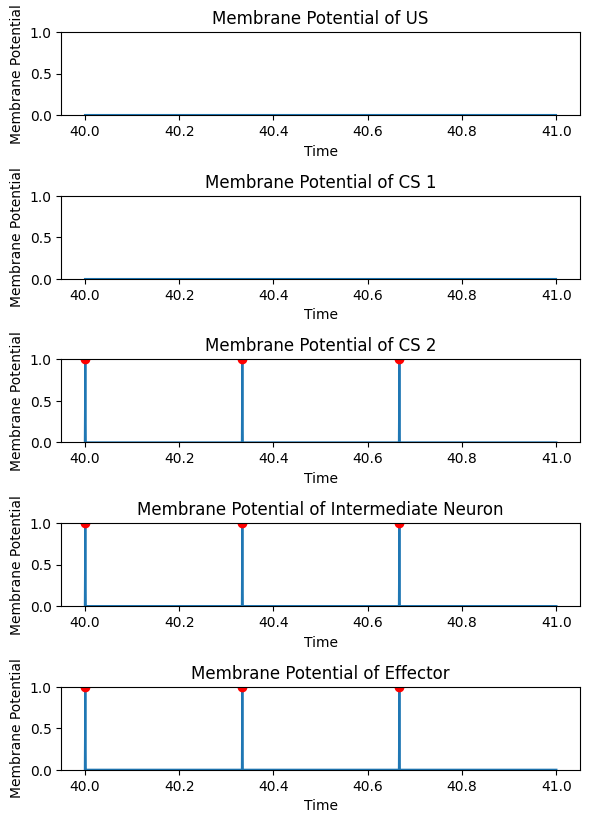


Abatement: Only CS 1 input after learning



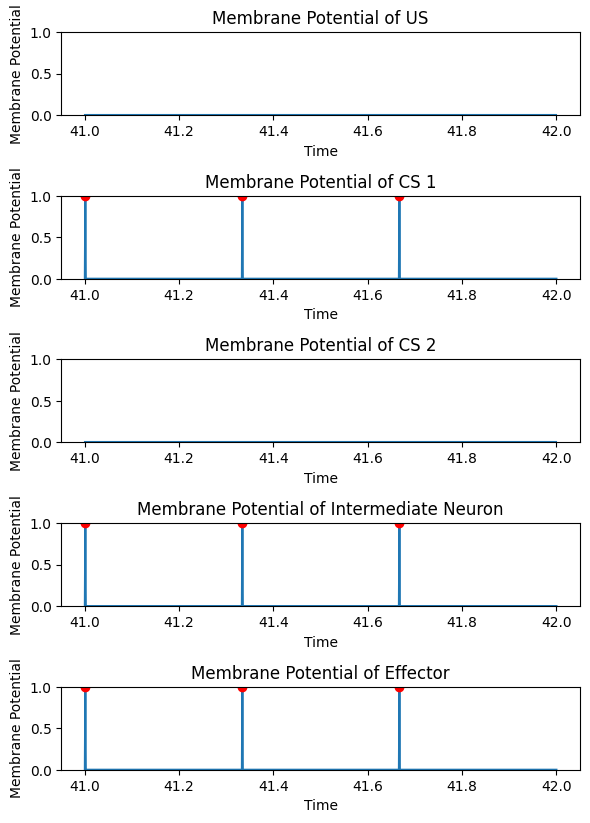

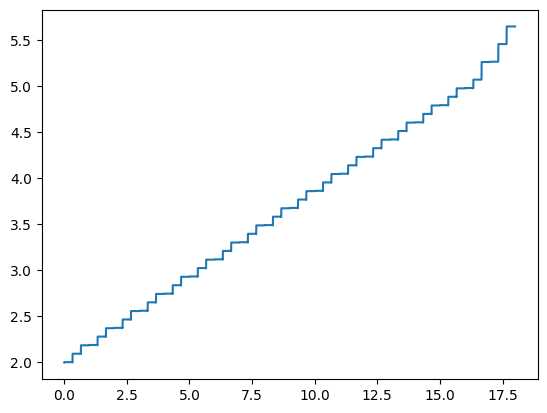

In [112]:
# Set simulation parameters
dt = 0.001  # Time step
sim_time = 1.0  # Simulation time

net = LeakySNN((3,1,1), dt, weight=2.0)
net.visualizeLayers()
net.layers[0][0].name = 'US'
net.layers[0][1].name = 'CS 1'
net.layers[0][2].name = 'CS 2'
net.layers[1][0].name = 'Intermediate Neuron'
net.layers[2][0].name = 'Effector'

us2intermediate_synapse = net.layers[0][0].post_synapses[0]
#us2intermediate_synapse.synapse_type = 'base'
us2intermediate_synapse.weight = 5.0

effector_synapse = net.layers[2][0].pre_synapses[0]
#effector_synapse.synapse_type = 'base'
effector_synapse.weight = 5.0

def getSpikeTrain(step):
    #'''
    if (step+333) % 333 == 0 and step < 900:
        return 5.0
    '''
    if 200 < step < 300:
        if step % 10 == 0:
            return 5.0
    '''
    return 0.0

# Simulate the neuron
trial = 0
num_steps = int(sim_time / dt)
learning_cycle = 17

print("\nControl: Only CS input before learning\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = getSpikeTrain(step)
    CS2_input = 0
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

print("\nControl: Only CS input before learning\n")
for step in range(num_steps):
    US_input = getSpikeTrain(step)
    CS1_input = 0
    CS2_input = 0
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

print("\nLearning: Both US input and CS input\n")
for step in range(num_steps):
    US_input = getSpikeTrain(step)
    CS1_input = getSpikeTrain(step + 5)
    CS2_input = 0
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

for i in range(learning_cycle):
    for step in range(num_steps):
        US_input = getSpikeTrain(step)
        CS1_input = getSpikeTrain(step + 5)
        CS2_input = 0
        x = [US_input,CS1_input, CS2_input]
        net.fullUpdate(x)
    #net.plotActivitySince(trial * num_steps)
    trial += 1

print("\nResult: Only CS input after learning\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = getSpikeTrain(step)
    CS2_input = 0
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

print("\n----------------------------------------\nWe now have classical conditioning on CS 1 established!\n----------------------------------------\n")

print("\nControl: Only CS 2 input before learning\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = 0
    CS2_input = getSpikeTrain(step)
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

obs_synapse = net.layers[0][2].post_synapses[0]
ts = [0]
ws = [obs_synapse.weight]

print("\nLearning: CS 1 and CS 2\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = getSpikeTrain(step)
    CS2_input = getSpikeTrain(step + 5)
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
    ts.append(ts[-1]+dt)
    ws.append(obs_synapse.weight)
net.plotActivitySince(trial * num_steps)
trial += 1

for i in range(learning_cycle):
    for step in range(num_steps):
        US_input = 0
        CS1_input = getSpikeTrain(step)
        CS2_input = getSpikeTrain(step + 5)
        x = [US_input,CS1_input, CS2_input]
        net.fullUpdate(x)
        ts.append(ts[-1]+dt)
        ws.append(obs_synapse.weight)
    #net.plotActivitySince(trial * num_steps)
    trial += 1

print("\nResult: Only CS 2 input after learning\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = 0
    CS2_input = getSpikeTrain(step)
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

print("\nAbatement: Only CS 1 input after learning\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = getSpikeTrain(step)
    CS2_input = 0
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

plt.plot(ts, ws)

In [ ]:
print("\nAbating training: Both CS 1 and CS 2 input after learning\n")
for i in range(learning_cycle):
    for step in range(num_steps):
        US_input = 0
        CS1_input = getSpikeTrain(step)
        CS2_input = getSpikeTrain(step + 5)
        x = [US_input,CS1_input, CS2_input]
        net.fullUpdate(x)
    net.plotActivitySince(trial * num_steps)
    trial += 1

print("\nAbatement: Only CS 1 input after learning\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = getSpikeTrain(step)
    CS2_input = 0
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

In [ ]:
print("\nAbatement: Only CS 2 input after abatement\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = 0
    CS2_input = getSpikeTrain(step)
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

## Experiment 3: NO intermediary neuron

<ipython-input-5-5242209498a5>:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_edges = cm.get_cmap('coolwarm')
<ipython-input-5-5242209498a5>:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_nodes = cm.get_cmap('cividis')
<ipython-input-5-5242209498a5>:138: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
<ipython-input-5-5242209498a5>:143: MatplotlibDeprecationWarning: Unable to d

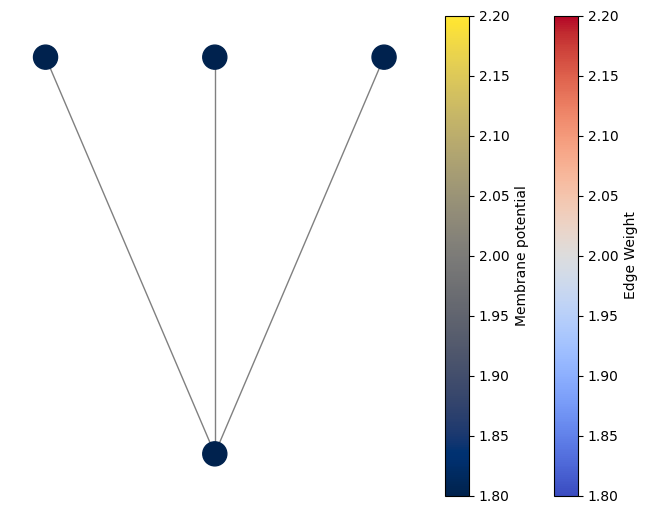


Control: Only CS input before learning



<Figure size 640x480 with 0 Axes>

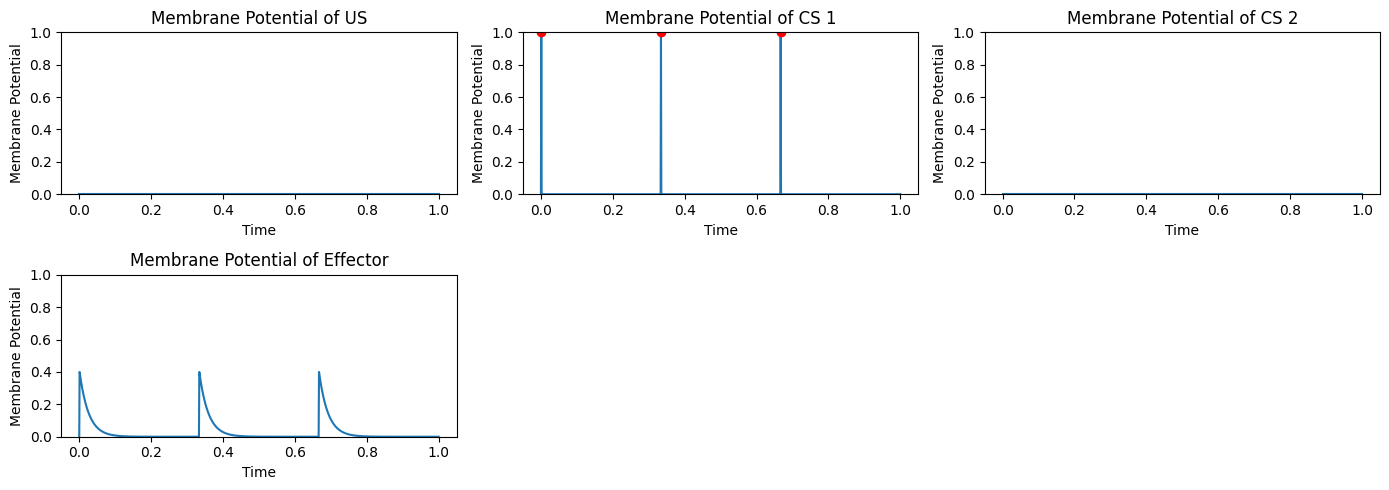


Control: Only CS input before learning



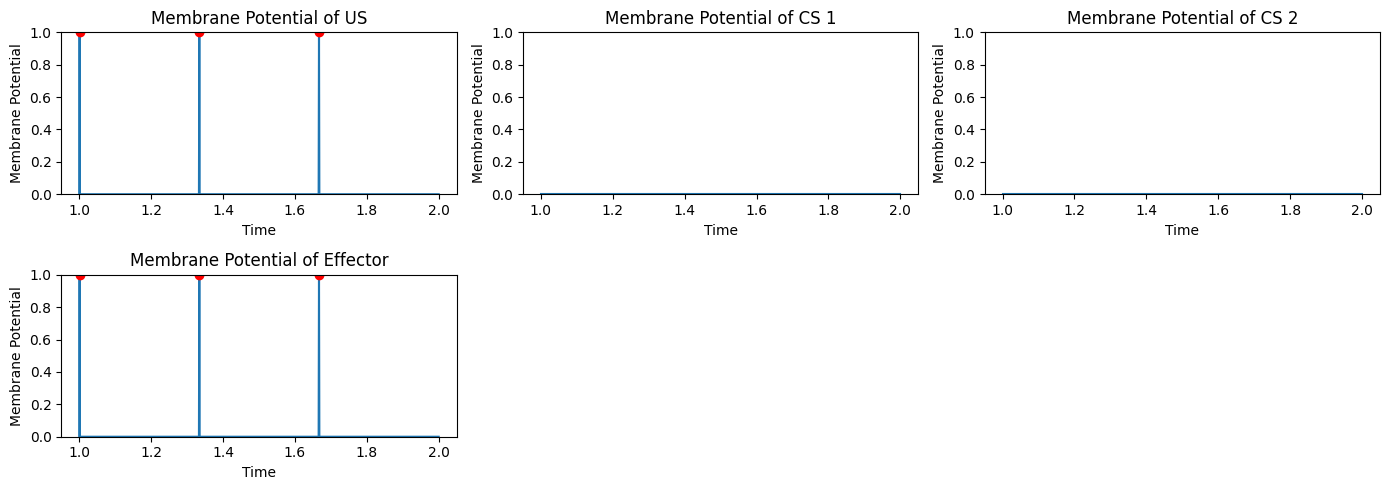


Learning: Both US input and CS input



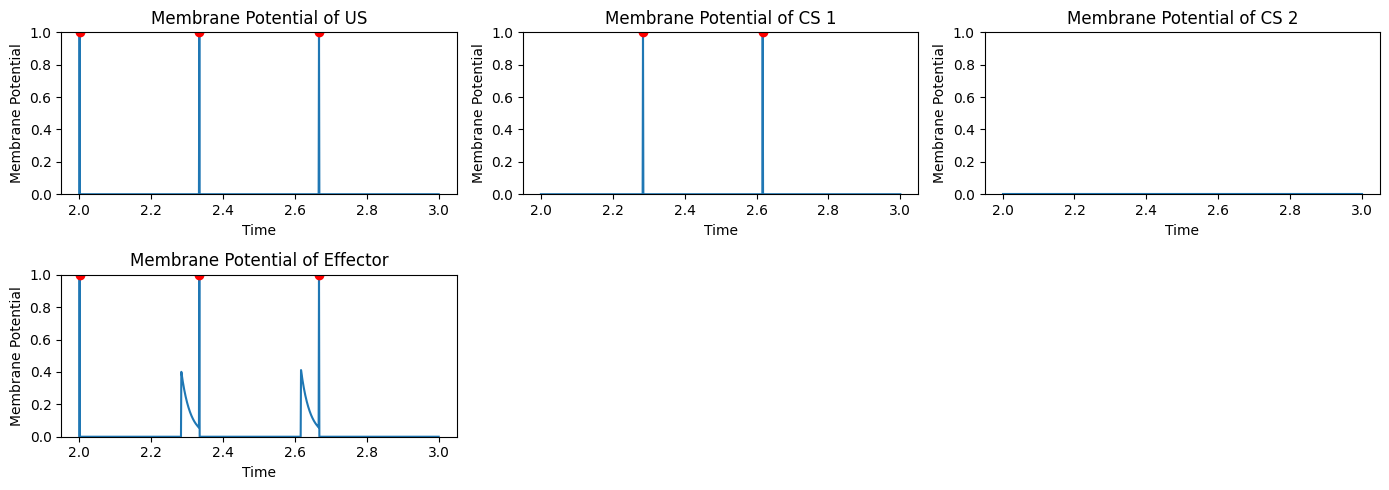


Result: Only CS input after learning



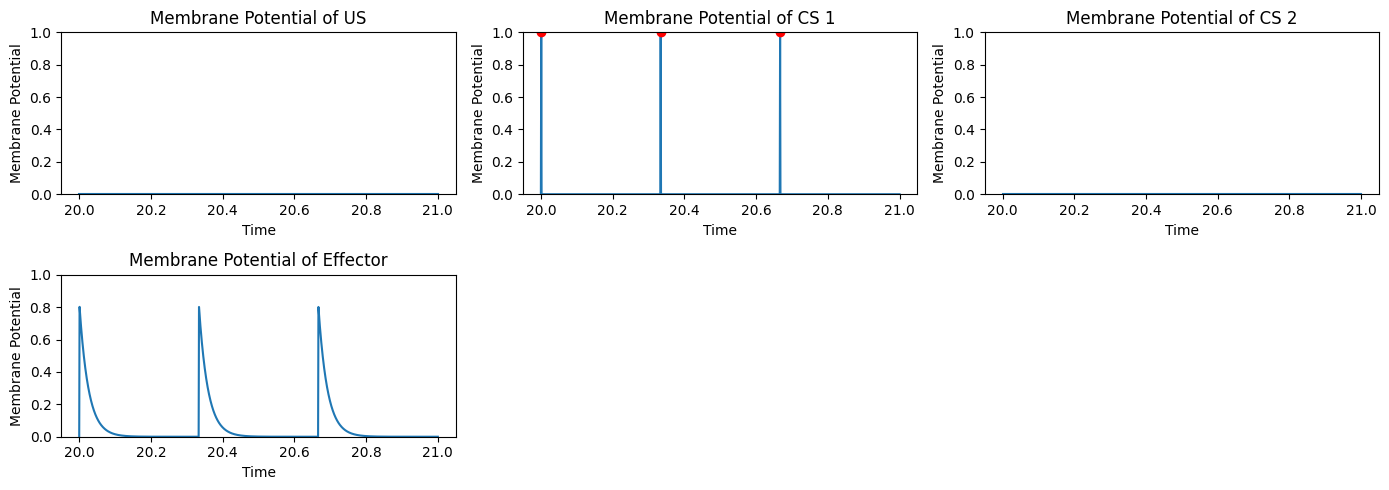


----------------------------------------
We now have classical conditioning on CS 1 established!
----------------------------------------


Control: Only CS 2 input before learning



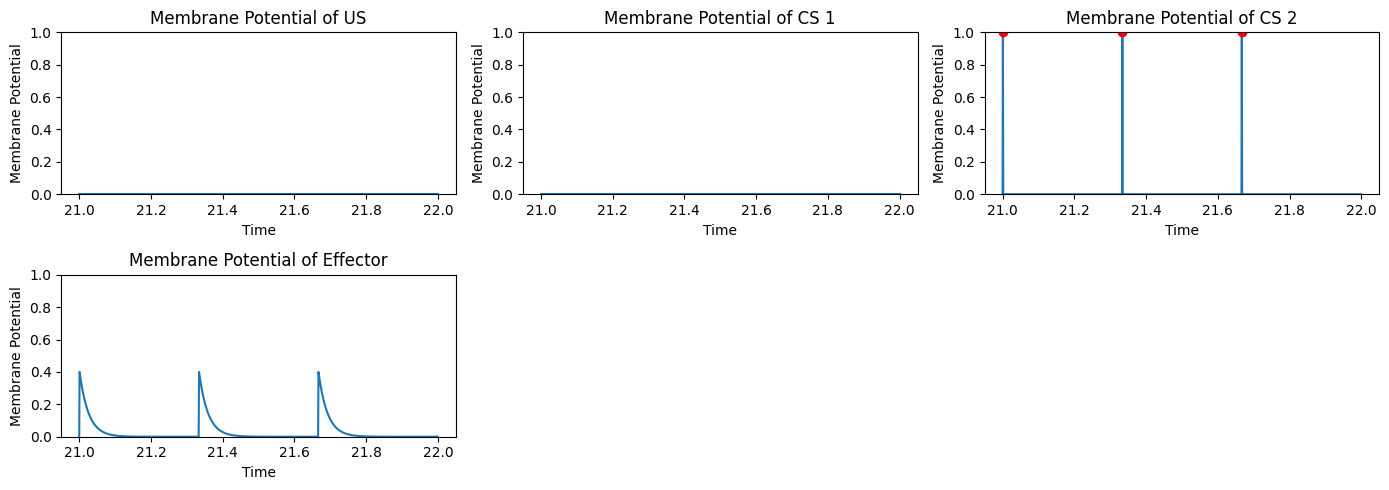


Learning: CS 1 and CS 2



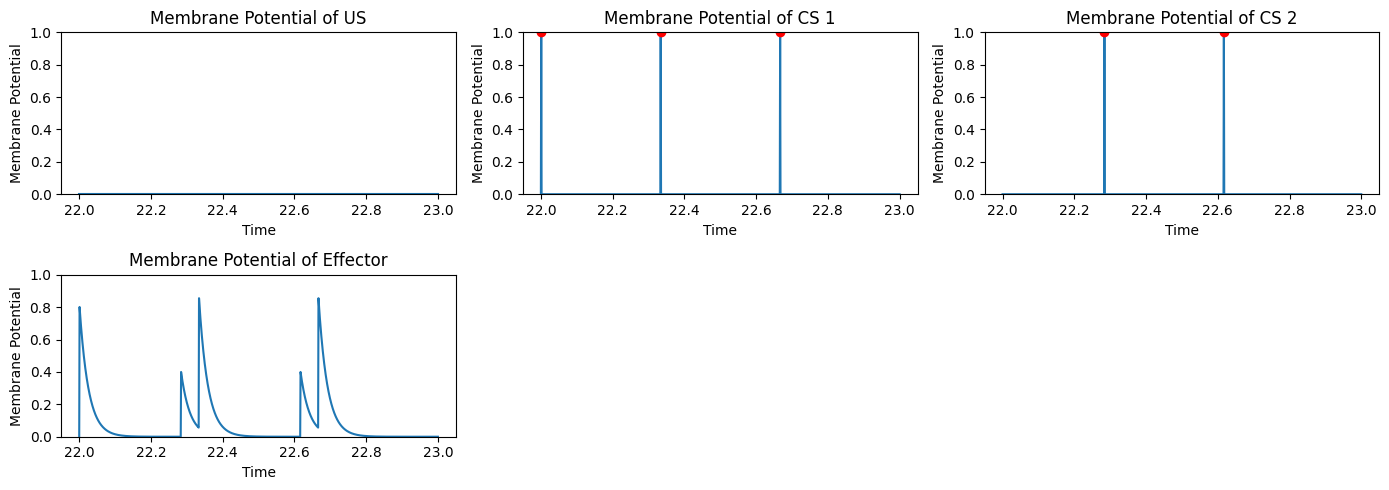


Result: Only CS 2 input after learning



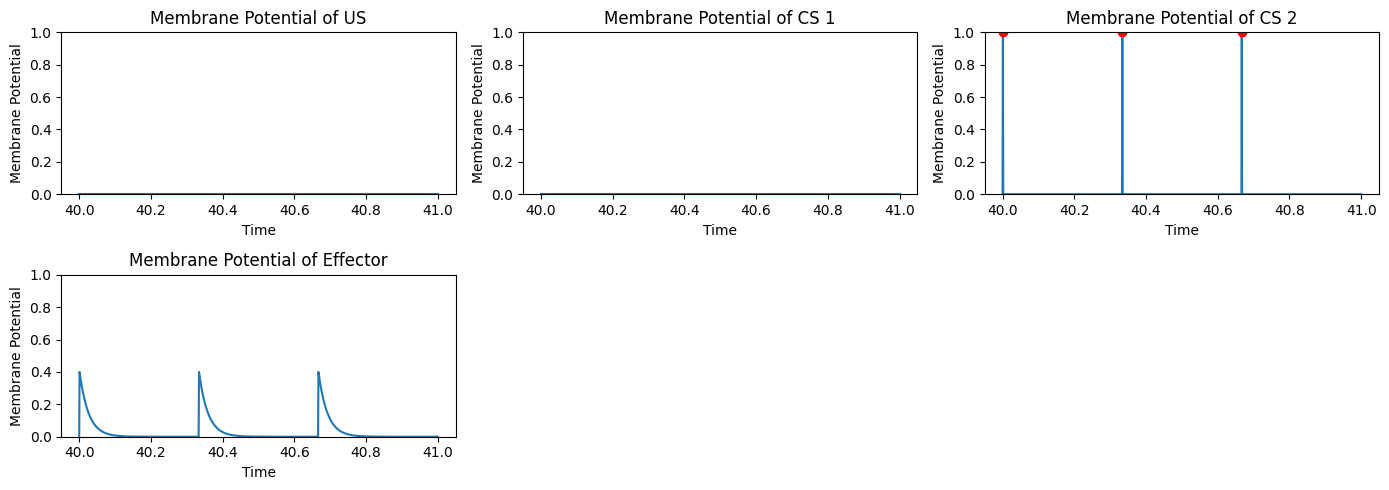


Abatement: Only CS 1 input after learning



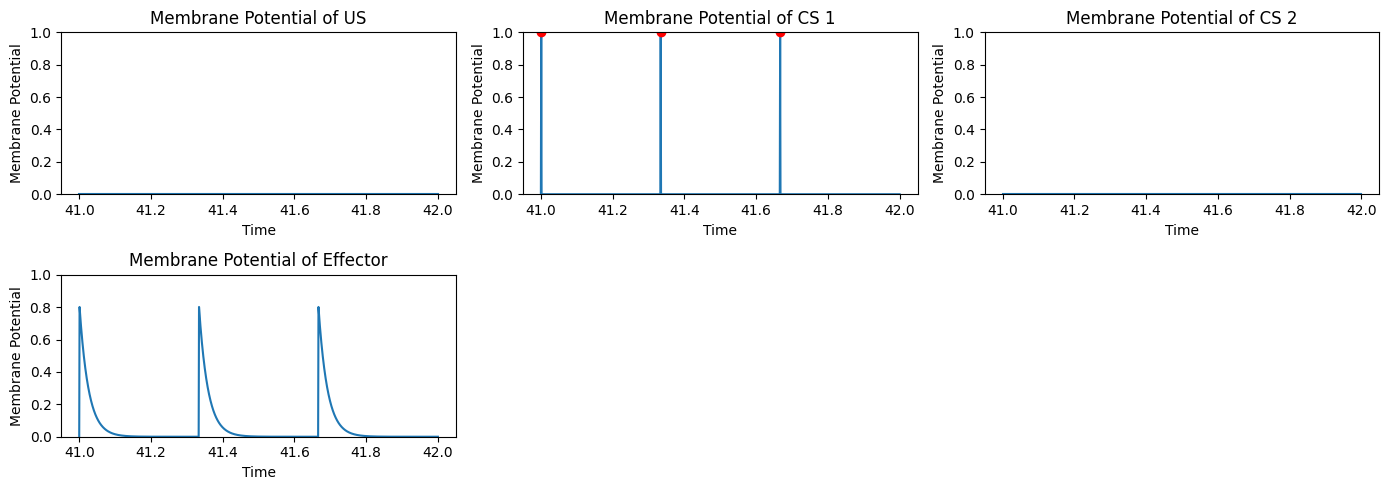

In [ ]:
# Set simulation parameters
dt = 0.001  # Time step
sim_time = 1.0  # Simulation time

net = LeakySNN((3,1), dt, weight=2.0)
net.visualizeLayers()
net.layers[0][0].name = 'US'
net.layers[0][1].name = 'CS 1'
net.layers[0][2].name = 'CS 2'
net.layers[1][0].name = 'Effector'

us2intermediate_synapse = net.layers[0][0].post_synapses[0]
#us2intermediate_synapse.synapse_type = 'base'
us2intermediate_synapse.weight = 5.0

effector_synapse = net.layers[1][0].pre_synapses[0]
#effector_synapse.synapse_type = 'base'
effector_synapse.weight = 5.0

def getSpikeTrain(step):
    #'''
    if (step+333) % 333 == 0 and step < 900:
        return 5.0
    '''
    if 200 < step < 300:
        if step % 10 == 0:
            return 5.0
    '''
    return 0.0

# Simulate the neuron
trial = 0
num_steps = int(sim_time / dt)
learning_cycle = 17

print("\nControl: Only CS input before learning\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = getSpikeTrain(step)
    CS2_input = 0
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

print("\nControl: Only CS input before learning\n")
for step in range(num_steps):
    US_input = getSpikeTrain(step)
    CS1_input = 0
    CS2_input = 0
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

print("\nLearning: Both US input and CS input\n")
for step in range(num_steps):
    US_input = getSpikeTrain(step)
    CS1_input = getSpikeTrain(step + 50)
    CS2_input = 0
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

for i in range(learning_cycle):
    for step in range(num_steps):
        US_input = getSpikeTrain(step)
        CS1_input = getSpikeTrain(step + 50)
        CS2_input = 0
        x = [US_input,CS1_input, CS2_input]
        net.fullUpdate(x)
    #net.plotActivitySince(trial * num_steps)
    trial += 1

print("\nResult: Only CS input after learning\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = getSpikeTrain(step)
    CS2_input = 0
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

print("\n----------------------------------------\nWe now have classical conditioning on CS 1 established!\n----------------------------------------\n")

print("\nControl: Only CS 2 input before learning\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = 0
    CS2_input = getSpikeTrain(step)
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

print("\nLearning: CS 1 and CS 2\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = getSpikeTrain(step)
    CS2_input = getSpikeTrain(step + 50)
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

for i in range(learning_cycle):
    for step in range(num_steps):
        US_input = 0
        CS1_input = getSpikeTrain(step)
        CS2_input = getSpikeTrain(step + 50)
        x = [US_input,CS1_input, CS2_input]
        net.fullUpdate(x)
    #net.plotActivitySince(trial * num_steps)
    trial += 1

print("\nResult: Only CS 2 input after learning\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = 0
    CS2_input = getSpikeTrain(step)
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1

print("\nAbatement: Only CS 1 input after learning\n")
for step in range(num_steps):
    US_input = 0
    CS1_input = getSpikeTrain(step)
    CS2_input = 0
    x = [US_input,CS1_input, CS2_input]
    net.fullUpdate(x)
net.plotActivitySince(trial * num_steps)
trial += 1


## Single-neuron simulation

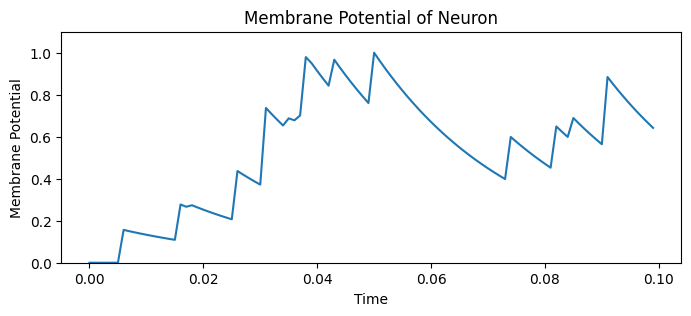

In [61]:
# Set simulation parameters
dt = 0.001  # Time step
sim_time = 0.1  # Simulation time

# Create a LeakyIntegrateAndFireNeuron instance
neuron = LeakyIntegrateAndFireNeuron()

# Lists to store the time and firing events
time = []
spike_events = []

# Simulate the neuron
num_steps = int(sim_time / dt)
for step in range(num_steps):
    #'''
    if random.random() < (20/num_steps):
        neuron.current = 2*random.random()
    else:
        neuron.current = 0
        #'''
    #current = 110.0 * random.random()  # Constant input current
    fired = neuron.update(step)

# Plot the membrane potential
neuron.plotLog()
